In [1]:
# from obspy modules import functions
from obspy import read, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.stream import Stream
# import matplotlib module
import matplotlib.pyplot as plt

# Part one: load and select data

In [2]:
# read the downloaded waveforms into obspy stream object
st = read('./2019-07-06-mw71-central-california-2.miniseed')

In [3]:
# select traces whose location is '10'
# use copy function to aviod processing original stream
st_10 = st.select(location='10').copy()

In [4]:
# from the IRIS webpage about this instrument
# channel 'BH1' azimuth and dip are 0 and 0
# channel 'BH2' azimuth and dip are 90 and 0
# thus, we rename 'BH1' into 'BHN'
# and rename 'BH2' into 'BHE'
# this is useful for waveform rotation
for tr in st_10:
    if tr.stats.channel == 'BH1':
        tr.stats.channel = 'BHN'
    if tr.stats.channel == 'BH2':
        tr.stats.channel = 'BHE'

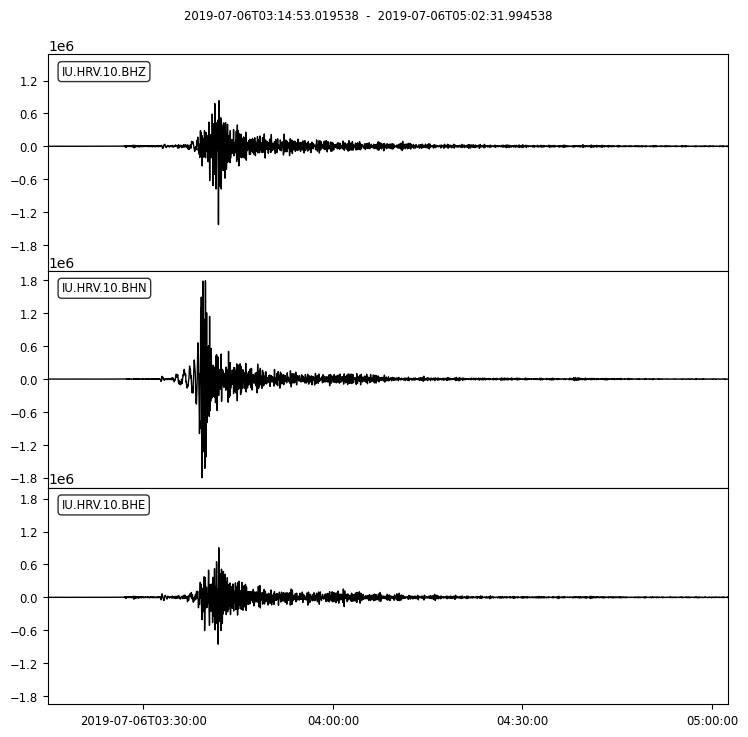

In [5]:
# quick check
st_10.plot();

# Question: To analyze surface wave, which coordinate system do you prefer? ZNE or ZRT?

# Part two: rotate data from locations

In [6]:
# event info
event_otime = UTCDateTime('2019-07-06 03:19:53')
event_longitude = -117.599333
event_latitude = 35.7695
event_depth = 8 # kilometer
event_magnitude = 7.1

In [7]:
# station info
station_longitude = -71.5583
station_latitude = 42.5064
station_elevation = 200.0 # meter
station_depth = 0.0

In [8]:
# compute epicentral distance, azimuth, and back azimuth
# for this earthquake-station pair
dist_in_m, az, baz = gps2dist_azimuth(event_latitude, event_longitude, station_latitude, station_longitude)
print('epicentral distance is: %.2f m'%dist_in_m)
print('azimuth is: %.2f'%az)
print('back azimuth is: %.2f'%baz)

epicentral distance is: 3999969.28 m
azimuth is: 64.89
back azimuth is: 274.97


In [9]:
# use the rotate function to rotate waveforms
# from ZNE coordinate system to ZRT coordinate system
st_10.rotate('NE->RT', back_azimuth=baz)

3 Trace(s) in Stream:
IU.HRV.10.BHR | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples
IU.HRV.10.BHT | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples
IU.HRV.10.BHZ | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples

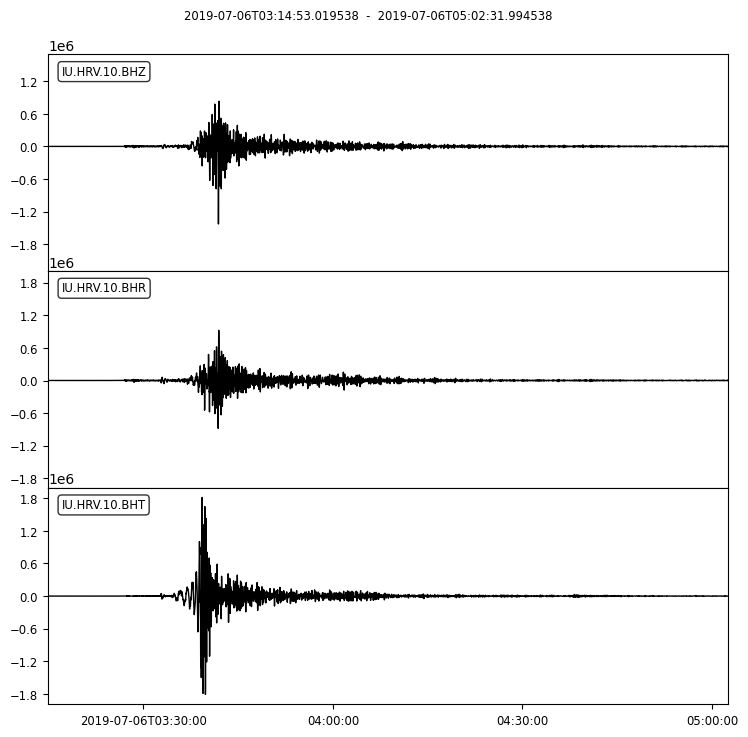

In [10]:
# quick check
# Note that Love wave in the transverse component
# Rayleigh wave in the radial and vertical components
st_10.plot();

# Part three: check ground motion of Rayleigh wave

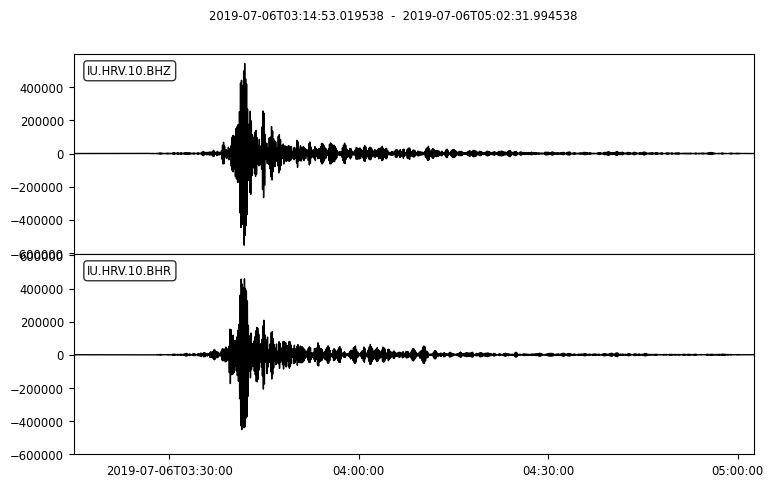

In [11]:
# first select vertical and radial components for analysis
st_BHRZ = st_10.select(component='[RZ]').copy()
# remove mean, linear trend, and taper at both ends
st_BHRZ.detrend('demean').detrend('linear').taper(0.05)
# apply a narrow bandpass filter to the raw waveform
# in this example: 8 s-12 s
st_BHRZ.filter('bandpass', freqmin=1/12., freqmax=1/8., corners=2, zerophase=True)
# quick plot
st_BHRZ.plot();

In [12]:
# further zoom into the Rayleigh wave part
st_ray = st_BHRZ.slice(starttime=UTCDateTime('2019-07-06 03:41:00'), endtime=UTCDateTime('2019-07-06 03:42:30'))

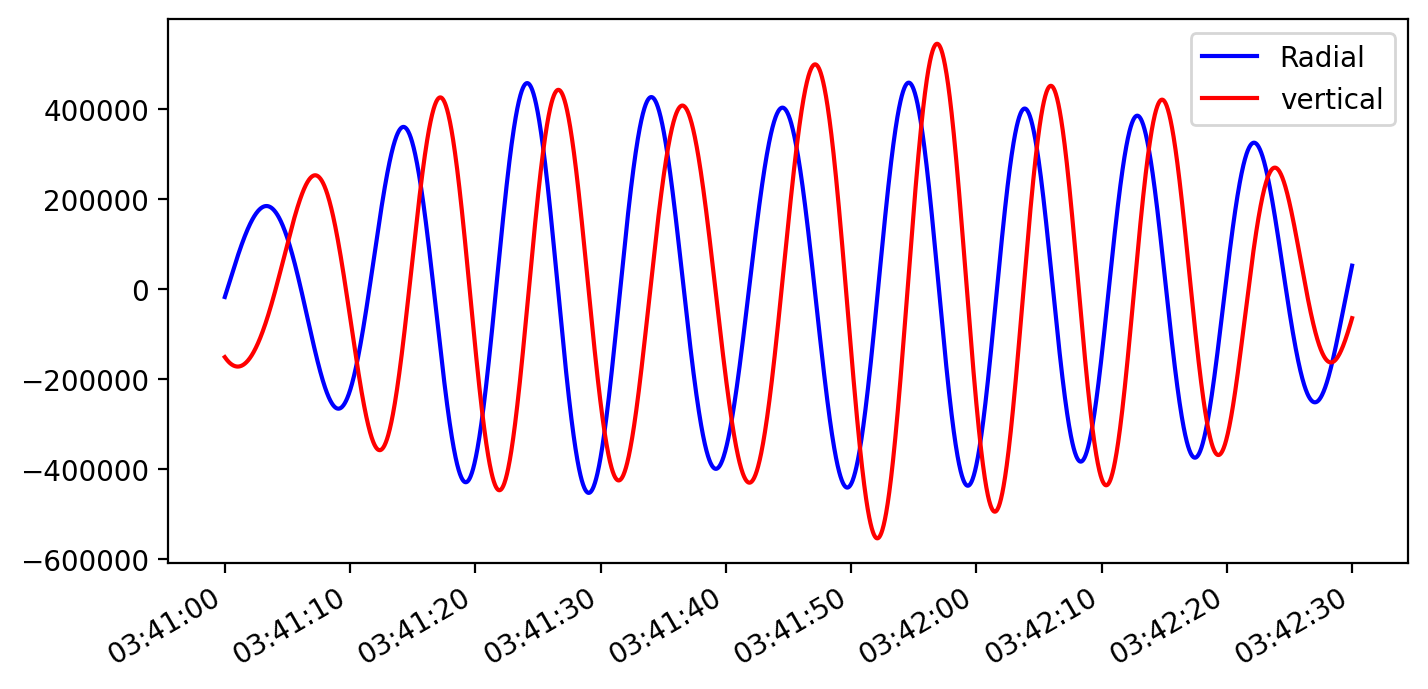

In [13]:
# plot both traces together
# can you observe the phase shift?
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 1, 1)
ax.plot(st_ray[0].times("matplotlib"), st_ray[0].data, "b-", label='Radial')
ax.plot(st_ray[1].times("matplotlib"), st_ray[1].data, "r-", label='vertical')
ax.xaxis_date()
fig.autofmt_xdate()
plt.legend(loc='upper right')
plt.show()

# Exercise: change starttime and endtime to see if phase delay exists in other windows. 